Learning Probability Density Functions Using Data (GAN)

Import required libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
import os

Dataset location check

In [2]:
# Check if dataset exists in parent folder
data_file = os.path.join('..', 'data.csv')
if not os.path.exists(data_file):
    print("ERROR: data.csv not found in parent Probability folder!")
    raise FileNotFoundError("Dataset file not found")
else:
    print("Dataset found ✓")

Dataset found ✓


Configuration and hyperparameters

In [3]:
r = 102303747
noise_dim = 10
epochs = 3000
batch_size = 64

a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print(f"Roll Number: {r}")
print(f"a_r = {a_r}")
print(f"b_r = {b_r}")

Roll Number: 102303747
a_r = 0.0
b_r = 0.8999999999999999


Load and transform data

In [4]:
df = pd.read_csv(data_file, encoding="latin1")
x = pd.to_numeric(df["no2"], errors="coerce").dropna().values.astype(np.float32)

z = x + a_r * np.sin(b_r * x)

print(f"Original data shape: {x.shape}")
print(f"Transformed data range: [{z.min():.2f}, {z.max():.2f}]")
print(f"Mean: {z.mean():.2f}, Std: {z.std():.2f}")

Original data shape: (419509,)
Transformed data range: [0.00, 876.00]
Mean: 25.81, Std: 18.50


C:\Users\bvidy\AppData\Local\Temp\ipykernel_6468\2653803634.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file, encoding="latin1")


Build Generator model

In [5]:
generator = Sequential([
    Dense(64, activation="relu", input_shape=(noise_dim,)),
    Dense(64, activation="relu"),
    Dense(1)
], name="Generator")

generator.summary()

c:\Users\bvidy\.conda\envs\tf\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,929 (19.25 KB)

 Trainable params: 4,929 (19.25 KB)

 Non-trainable params: 0 (0.00 B)

Build Discriminator model

In [6]:
discriminator = Sequential([
    Dense(64, activation="relu", input_shape=(1,)),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
], name="Discriminator")

discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(0.0004),
    loss="binary_crossentropy"
)

discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

Build combined GAN model

In [7]:
discriminator.trainable = False
noise_input = Input(shape=(noise_dim,))
fake = generator(noise_input)
validity = discriminator(fake)

gan = Model(noise_input, validity, name="GAN")
gan.compile(
    optimizer=tf.keras.optimizers.Adam(0.0004),
    loss="binary_crossentropy"
)

gan.summary()

Model: "GAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator (Sequential)          │ (None, 1)              │         4,929 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Sequential)      │ (None, 1)              │         4,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,282 (36.26 KB)

 Trainable params: 4,929 (19.25 KB)

 Non-trainable params: 4,353 (17.00 KB)

Train the GAN

In [8]:
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

print("Training GAN...\n")

for epoch in range(epochs):
    # Select random real samples
    idx = np.random.randint(0, len(z), batch_size)
    real_samples = z[idx].reshape(-1, 1)
    
    # Generate fake samples
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    fake_samples = generator.predict(noise, verbose=0)
    
    # Train discriminator
    discriminator.trainable = True
    d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
    
    # Train generator
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, real_labels)
    
    if epoch % 300 == 0:
        print(f"Epoch {epoch}/{epochs} | D Loss: {(d_loss_real + d_loss_fake)/2:.4f} | G Loss: {g_loss:.4f}")

print("\nTraining completed!")

Training GAN...

Epoch 0/3000 | D Loss: 0.5725 | G Loss: 0.6806
Epoch 300/3000 | D Loss: 0.5605 | G Loss: 0.7092
Epoch 600/3000 | D Loss: 0.6300 | G Loss: 0.7841
Epoch 900/3000 | D Loss: 0.6509 | G Loss: 0.7597
Epoch 1200/3000 | D Loss: 0.6629 | G Loss: 0.7477
Epoch 1500/3000 | D Loss: 0.6700 | G Loss: 0.7399
Epoch 1800/3000 | D Loss: 0.6746 | G Loss: 0.7330
Epoch 2100/3000 | D Loss: 0.6780 | G Loss: 0.7278
Epoch 2400/3000 | D Loss: 0.6804 | G Loss: 0.7241
Epoch 2700/3000 | D Loss: 0.6823 | G Loss: 0.7209

Training completed!


Generate samples and compute statistics

In [9]:
noise = np.random.normal(0, 1, (6000, noise_dim))
z_fake = generator.predict(noise, verbose=0).flatten()

print("\nStatistics Comparison:")
print(f"Real Mean: {np.mean(z):.6f}")
print(f"Generated Mean: {np.mean(z_fake):.6f}")
print(f"\nReal Standard Deviation: {np.std(z):.6f}")
print(f"Generated Standard Deviation: {np.std(z_fake):.6f}")


Statistics Comparison:
Real Mean: 25.809626
Generated Mean: 24.909023

Real Standard Deviation: 18.503065
Generated Standard Deviation: 14.099981


Visualize learned PDF

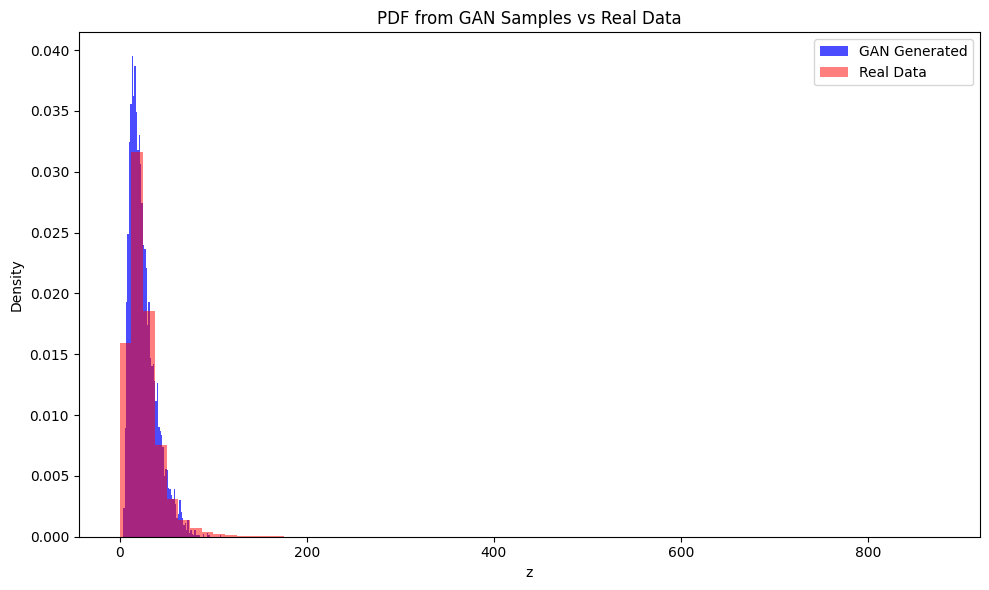

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(z_fake, bins=70, density=True, alpha=0.7, color='blue', label='GAN Generated')
plt.hist(z, bins=70, density=True, alpha=0.5, color='red', label='Real Data')
plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF from GAN Samples vs Real Data")
plt.legend()
plt.tight_layout()
plt.savefig("gan_pdf.png", dpi=300)
plt.show()